In [1]:
%matplotlib widget

from __future__ import annotations

from collections import defaultdict
from dataclasses import dataclass, field
from itertools import product
from math import inf
from random import choice

import numpy as np

from numpy import int_, object_
from numpy.typing import NDArray

import matplotlib.colors as mcolors
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import axes3d

import re

from util import print_hex

COLORS = list(mcolors.CSS4_COLORS.keys())


<link href="style.css" rel="stylesheet"></link>
<main>
<article class="day-desc read-aloud"><h2>--- Day 23: A Long Walk ---</h2><p>The Elves resume water filtering operations! Clean water starts flowing over the edge of Island Island.</p>
<p>They offer to help <em>you</em> go over the edge of Island Island, too! Just <span title="It'll be fiiiiiiiine.">hold on tight</span> to one end of this impossibly long rope and they'll lower you down a safe distance from the massive waterfall you just created.</p>
<p>As you finally reach Snow Island, you see that the water isn't really reaching the ground: it's being <em>absorbed by the air</em> itself. It looks like you'll finally have a little downtime while the moisture builds up to snow-producing levels. Snow Island is pretty scenic, even without any snow; why not take a walk?</p>
<p>There's a map of nearby hiking trails (your puzzle input) that indicates <em>paths</em> (<code>.</code>), <em>forest</em> (<code>#</code>), and steep <em>slopes</em> (<code>^</code>, <code>&gt;</code>, <code>v</code>, and <code>&lt;</code>).</p>
<p>For example:</p>
<pre><code>#.#####################
#.......#########...###
#######.#########.#.###
###.....#.&gt;.&gt;.###.#.###
###v#####.#v#.###.#.###
###.&gt;...#.#.#.....#...#
###v###.#.#.#########.#
###...#.#.#.......#...#
#####.#.#.#######.#.###
#.....#.#.#.......#...#
#.#####.#.#.#########v#
#.#...#...#...###...&gt;.#
#.#.#v#######v###.###v#
#...#.&gt;.#...&gt;.&gt;.#.###.#
#####v#.#.###v#.#.###.#
#.....#...#...#.#.#...#
#.#########.###.#.#.###
#...###...#...#...#.###
###.###.#.###v#####v###
#...#...#.#.&gt;.&gt;.#.&gt;.###
#.###.###.#.###.#.#v###
#.....###...###...#...#
#####################.#
</code></pre>
<p>You're currently on the single path tile in the top row; your goal is to reach the single path tile in the bottom row. Because of all the mist from the waterfall, the slopes are probably quite <em>icy</em>; if you step onto a slope tile, your next step must be <em>downhill</em> (in the direction the arrow is pointing). To make sure you have the most scenic hike possible, <em>never step onto the same tile twice</em>. What is the longest hike you can take?</p>
<p>In the example above, the longest hike you can take is marked with <code>O</code>, and your starting position is marked <code>S</code>:</p>
<pre><code>#S#####################
#OOOOOOO#########...###
#######O#########.#.###
###OOOOO#OOO&gt;.###.#.###
###O#####O#O#.###.#.###
###OOOOO#O#O#.....#...#
###v###O#O#O#########.#
###...#O#O#OOOOOOO#...#
#####.#O#O#######O#.###
#.....#O#O#OOOOOOO#...#
#.#####O#O#O#########v#
#.#...#OOO#OOO###OOOOO#
#.#.#v#######O###O###O#
#...#.&gt;.#...&gt;OOO#O###O#
#####v#.#.###v#O#O###O#
#.....#...#...#O#O#OOO#
#.#########.###O#O#O###
#...###...#...#OOO#O###
###.###.#.###v#####O###
#...#...#.#.&gt;.&gt;.#.&gt;O###
#.###.###.#.###.#.#O###
#.....###...###...#OOO#
#####################O#
</code></pre>
<p>This hike contains <code><em>94</em></code> steps. (The other possible hikes you could have taken were <code>90</code>, <code>86</code>, <code>82</code>, <code>82</code>, and <code>74</code> steps long.)</p>
<p>Find the longest hike you can take through the hiking trails listed on your map. <em>How many steps long is the longest hike?</em></p>
</article>

</main>


In [2]:
from collections import deque
from functools import cache

from tabulate import tabulate


s = """
#.#####################
#.......#########...###
#######.#########.#.###
###.....#.>.>.###.#.###
###v#####.#v#.###.#.###
###.>...#.#.#.....#...#
###v###.#.#.#########.#
###...#.#.#.......#...#
#####.#.#.#######.#.###
#.....#.#.#.......#...#
#.#####.#.#.#########v#
#.#...#...#...###...>.#
#.#.#v#######v###.###v#
#...#.>.#...>.>.#.###.#
#####v#.#.###v#.#.###.#
#.....#...#...#.#.#...#
#.#########.###.#.#.###
#...###...#...#...#.###
###.###.#.###v#####v###
#...#...#.#.>.>.#.>.###
#.###.###.#.###.#.#v###
#.....###...###...#...#
#####################.#
"""


class Map:
    directions = {
        ".": ((0, 1), (1, 0), (0, -1), (-1, 0)),
        "^": ((-1, 0),),
        ">": ((0, 1),),
        "v": ((1, 0),),
        "<": ((0, -1),),
    }

    def __init__(self, s: str) -> None:
        self.map = [list(l) for l in s.strip().splitlines()]

    def longest_path_dfs_stack_too_big(self) -> int:
        def dfs(r: int, c: int) -> int:
            if not (0 <= r < rows and 0 <= c < cols):
                return 0
            if self.map[r][c] in "O#":
                return 0

            if r == rows - 1 and c == cols - 2:
                return 1

            old_value = self.map[r][c]
            self.map[r][c] = "O"

            max_path = max(
                (dfs(r + dr, c + dc) for dr, dc in self.directions[old_value]),
                default=0,
            )

            self.map[r][c] = old_value
            return max_path + 1 if max_path else 0

        rows, cols = len(self.map), len(self.map[0])
        return dfs(0, 1) - 1

    def longest_path_bfs(self):
        rows, cols = len(self.map), len(self.map[0])

        queue = deque([(0, 1, frozenset())])
        paths = []

        while queue:
            r, c, path = queue.popleft()
            if not (0 <= r < rows and 0 <= c < cols):
                continue

            if self.map[r][c] == "#" or (r, c) in path:
                continue

            if r == rows - 1 and c == cols - 2:
                paths.append(path)
                continue

            queue.extend(
                (r + dr, c + dc, path | {(r, c)})
                for dr, dc in self.directions[self.map[r][c]]
            )

        return max(len(p) for p in paths)

    def longest_path_dfs(self):
        rows, cols = len(self.map), len(self.map[0])

        queue = deque([(0, 1, frozenset())])
        paths = []

        while queue:
            r, c, path = queue.pop()
            if not (0 <= r < rows and 0 <= c < cols):
                continue

            if self.map[r][c] == "#" or (r, c) in path:
                continue

            if r == rows - 1 and c == cols - 2:
                paths.append(path)
                continue

            queue.extend(
                (r + dr, c + dc, path | {(r, c)})
                for dr, dc in self.directions[self.map[r][c]]
            )

        return max(len(p) for p in paths)

    def __str__(self) -> str:
        return "\n".join("".join(line) for line in self.map)

    def __repr__(self) -> str:
        return self.__str__()


map_example = Map(s)
print(f"{map_example.longest_path_bfs()=}")
print(f"{map_example.longest_path_dfs()=}")
print("Sould be 94")

map_example.longest_path_bfs()=94
map_example.longest_path_dfs()=94
Sould be 94


In [3]:
import time


with open("../input/day23.txt") as f:
    map_file = Map(f.read())
    tic = time.perf_counter()
    print(f"{map_file.longest_path_bfs()=}")
    toc = time.perf_counter()
    print(f"longest_path_bfs in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()
    print(f"{map_file.longest_path_dfs()=}")
    toc = time.perf_counter()
    print(f"longest_path_dfs in {toc - tic:0.4f} seconds")

map_file.longest_path_bfs()=2250
longest_path_bfs in 26.7275 seconds
map_file.longest_path_dfs()=2250
longest_path_dfs in 13.2867 seconds


<link href="style.css" rel="stylesheet"></link>

<main>

<p>Your puzzle answer was <code>2250</code>.</p><p class="day-success">The first half of this puzzle is complete! It provides one gold star: *</p>
<article class="day-desc"><h2 id="part2">--- Part Two ---</h2><p>As you reach the trailhead, you realize that the ground isn't as slippery as you expected; you'll have <em>no problem</em> climbing up the steep slopes.</p>
<p>Now, treat all <em>slopes</em> as if they were normal <em>paths</em> (<code>.</code>). You still want to make sure you have the most scenic hike possible, so continue to ensure that you <em>never step onto the same tile twice</em>. What is the longest hike you can take?</p>
<p>In the example above, this increases the longest hike to <code><em>154</em></code> steps:</p>
<pre><code>#S#####################
#OOOOOOO#########OOO###
#######O#########O#O###
###OOOOO#.&gt;OOO###O#O###
###O#####.#O#O###O#O###
###O&gt;...#.#O#OOOOO#OOO#
###O###.#.#O#########O#
###OOO#.#.#OOOOOOO#OOO#
#####O#.#.#######O#O###
#OOOOO#.#.#OOOOOOO#OOO#
#O#####.#.#O#########O#
#O#OOO#...#OOO###...&gt;O#
#O#O#O#######O###.###O#
#OOO#O&gt;.#...&gt;O&gt;.#.###O#
#####O#.#.###O#.#.###O#
#OOOOO#...#OOO#.#.#OOO#
#O#########O###.#.#O###
#OOO###OOO#OOO#...#O###
###O###O#O###O#####O###
#OOO#OOO#O#OOO&gt;.#.&gt;O###
#O###O###O#O###.#.#O###
#OOOOO###OOO###...#OOO#
#####################O#
</code></pre>
<p>Find the longest hike you can take through the surprisingly dry hiking trails listed on your map. <em>How many steps long is the longest hike?</em></p>
</article>

</main>


154 154


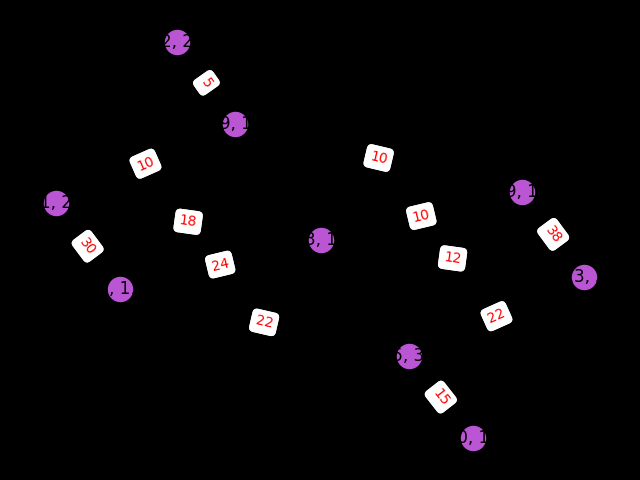

In [4]:
import matplotlib.pyplot as plt
import networkx as nx


class G:
    def __init__(self, s: str) -> None:
        regex = re.compile(r"[<|>|^|v]")
        self.m = re.sub(regex, ".", s).strip().splitlines()
        self.rows, self.cols = len(self.m), len(self.m[0])
        self.end = self.rows - 1, self.cols - 1

        crossroads = [(0, 1)]
        queue = []
        for r, c in product(range(1, self.rows - 1), range(1, self.cols - 1)):
            if self.m[r][c] == ".":
                count = sum(
                    1
                    for dr, dc in ((1, 0), (0, 1), (-1, 0), (0, -1))
                    if self.m[r + dr][c + dc] == "."
                )
                if count > 2:
                    crossroads.append((r, c))
                    queue.extend(
                        (r, c, r + dr, c + dc)
                        for dr, dc in ((1, 0), (0, 1), (-1, 0), (0, -1))
                        if self.m[r + dr][c + dc] == "."
                    )
        crossroads.append((self.rows - 1, self.cols - 2))
        graph = {(r, c): {} for r, c in crossroads}
        crossroads = set(crossroads)

        for cr, cc, r, c in queue:
            path = {(cr, cc)}
            while (r, c) not in crossroads:
                path.add((r, c))
                r, c = next(
                    (r + dr, c + dc)
                    for dr, dc in ((1, 0), (0, 1), (-1, 0), (0, -1))
                    if self.m[r + dr][c + dc] == "." and (r + dr, c + dc) not in path
                )
            path.add((r, c))
            graph[(cr, cc)][(r, c)] = len(path) - 1
            graph[(r, c)][(cr, cc)] = len(path) - 1

        self.graph = graph

    def longest_path(self) -> int:
        stack = [(0, 1, 0, set())]

        max_length = 0
        while stack:
            r, c, w, p = stack.pop()

            if (r, c) in p:
                continue

            if (r, c) == (self.rows - 1, self.cols - 2):
                max_length = max(max_length, w)
            else:
                stack.extend(
                    (rr, cc, w + ww, p | {(r, c)})
                    for (rr, cc), ww in self.graph[(r, c)].items()
                )

        return max_length

    def longest_path_rec(self) -> int:
        def dfs(r, c, length):
            if (r, c) in visited:
                return 0

            if (r, c) == (self.rows - 1, self.cols - 2):
                return length

            visited.add((r, c))
            max_length = max(
                dfs(rr, cc, length + self.graph[(r, c)][(rr, cc)])
                for rr, cc in self.graph[(r, c)].keys()
            )
            visited.remove((r, c))
            return max_length

        visited = set()
        return dfs(0, 1, 0)

    def plot_graph(self):
        plt.close()

        G = nx.Graph()  # create an empty object

        G.add_nodes_from(self.graph.keys())
        G.add_edges_from(
            (fr, to) for fr, tos in self.graph.items() for to in tos.keys()
        )
        edge_labels = {
            (fr, to): w for fr, tos in self.graph.items() for to, w in tos.items()
        }
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True, node_color="MediumOrchid")
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color="red")
        plt.show()

    def __str__(self) -> str:
        s = "    "
        s += "".join(
            f"{c // 10 // 10 if c % 100 == 0 else ' '}" for c in range(self.cols)
        )
        s += "\n    "
        s += "".join(
            f"{(c // 10 % 10) if c % 10 == 0 else ' '}" for c in range(self.cols)
        )
        s += "\n    "
        s += "".join(str(c % 10) for c in range(self.cols))
        s += "\n"
        return s + "\n".join(
            f"{r // 100 if r % 100 == 0 else ' '}{(r // 10) % 10 if r % 10 == 0 else ' '}{r % 10} {f''.join(l)}"
            for r, l in enumerate(self.m)
        )

    def __repr__(self) -> str:
        return self.__str__()


g = G(s)
print(g.longest_path(), g.longest_path_rec())
g.plot_graph()

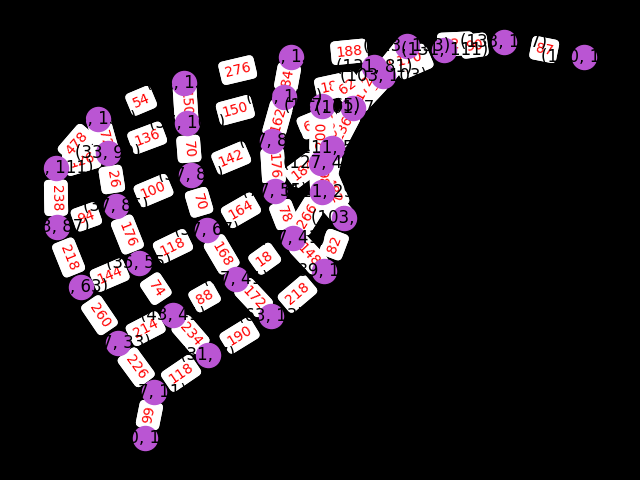

map_file.longest_path()=6470
longest_path in 143.7362 seconds
map_file.longest_path_rec()=6470
longest_path_rec in 132.8737 seconds


In [6]:
import time


with open("../input/day23.txt") as f:
    map_file = G(f.read())
    map_file.plot_graph()
    tic = time.perf_counter()
    print(f"{map_file.longest_path()=}")
    toc = time.perf_counter()
    print(f"longest_path in {toc - tic:0.4f} seconds")
    tic = time.perf_counter()
    print(f"{map_file.longest_path_rec()=}")
    toc = time.perf_counter()
    print(f"longest_path_rec in {toc - tic:0.4f} seconds")

<link href="style.css" rel="stylesheet"></link>

<main>

<p>Your puzzle answer was <code>6470</code>.</p><p class="day-success">Both parts of this puzzle are complete! They provide two gold stars: **</p>
<p>At this point, you should <a href="/2023">return to your Advent calendar</a> and try another puzzle.</p>

</main>
